In [4]:
# Initial setup
from __future__ import division
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import climlab
from builtins import next
from climlab.process.diagnostic import DiagnosticProcess
from climlab.domain.field import Field, global_mean

class tanalbedo(DiagnosticProcess):

    def __init__(self, **kwargs):
        super(tanalbedo, self).__init__(**kwargs)

        self.add_diagnostic('albedo')
        Ts = self.state['Ts']
        self._compute_fixed()

    def _compute_fixed(self):
        Ts = self.state['Ts']
        try:
            lon, lat = np.meshgrid(self.lon, self.lat)
        except:
            lat = self.lat
        phi = lat

        try:
            albedo=np.zeros(len(phi));
            albedo=0.42-0.20*np.tanh(0.052*(Ts-3))

        except:
            albedo = np.zeros_like(phi)

        dom = next(iter(self.domains.values()))
        self.albedo = Field(albedo, domain=dom)

    def _compute(self):
        self._compute_fixed()
        return {}


class simple_EBM_seasonal(climlab.model.ebm.EBM_seasonal):
    
    def __init__(self, orbit={'ecc': 0.0167643, 'long_peri': 280.32687, 'obliquity': 23.459277}, albedo='constant', Tf=-10.0, CO2=300, **kwargs):
        super().__init__(**kwargs)
        self.remove_subprocess('insolation')
        self.remove_subprocess('SW')
        self.remove_subprocess('albedo')
        self.remove_subprocess('LW')

        # catch model domain for subprocess creation
        surface = self.domains['Ts']
        # define new insolation and SW process
        insolation = climlab.radiation.DailyInsolation(domains=surface, orb = orbit, **self.param)
        
        # now define albedo process
        if albedo=='constant':
            alb = climlab.surface.albedo.ConstantAlbedo(domains=surface, **self.param)
        elif albedo=='step':
            alb = climlab.surface.albedo.StepFunctionAlbedo(state=self.state, Tf=Tf, **self.param)
        elif albedo=='tanh':
            alb = tanalbedo(state=self.state, **self.param)
        else:
            print('The given albedo option is not known. Will put in constant albedo.')
            alb = climlab.surface.albedo.ConstantAlbedo(domains=surface, **self.param)
        
        SW = climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave(insolation=insolation.insolation, state = self.state, albedo = alb.albedo, **self.param)
        LW = climlab.radiation.aplusbt.AplusBT_CO2(CO2=CO2, state=self.state, **self.param)
        self.add_subprocess('LW', LW)
        self.add_subprocess('insolation', insolation)
        self.add_subprocess('SW', SW)
        self.add_subprocess('albedo', alb)
        self.compute_diagnostics()
    
    def global_annual_mean(self):
        num_steps_per_year = int(self.time['num_steps_per_year'])
        mean_year = np.empty(num_steps_per_year)
        for m in range(num_steps_per_year):
            self.step_forward()
            mean_year[m] = self.global_mean_temperature()
        gam = np.mean(mean_year)
        return gam
    
        
    def plot_temp_rad(self):
        # creating plot figure
        fig = plt.figure(figsize=(15,5))

        # Temperature plot
        ax1 = fig.add_subplot(121)
        ax1.plot(self.lat,self.Ts)

        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_xlim([-90,90])
        ax1.set_title('Surface Temperature', fontsize=14)
        ax1.set_ylabel('(degC)', fontsize=12)
        ax1.grid()

        # Net Radiation plot
        ax3 = fig.add_subplot(122, sharex = ax1)
        ax3.plot(self.lat, self.OLR, label='OLR',
                                               color='cyan')
        ax3.plot(self.lat, self.ASR, label='ASR',
                                               color='magenta')
        ax3.plot(self.lat, self.ASR-self.OLR, 
                                               label='net radiation',
                                               color='red')

        ax3.set_title('Net Radiation', fontsize=14)
        ax3.set_ylabel('(W/m$^2$)', fontsize=12)
        ax3.legend(loc='best')
        ax3.grid()
        plt.show()
        
    def plot_timeave(self):
        # integrate for one year
        self.integrate_years(1.)
        
        # creating plot figure
        fig = plt.figure(figsize=(15,5))

        # Temperature plot
        ax1 = fig.add_subplot(121)
        ax1.plot(self.lat,self.timeave['Ts'])

        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_xlim([-90,90])
        ax1.set_title('Annual mean Surface Temperature', fontsize=14)
        ax1.set_ylabel('(degC)', fontsize=12)
        ax1.grid()

        # Net Radiation plot
        ax3 = fig.add_subplot(122, sharex = ax1)
        ax3.plot(self.lat, self.timeave['OLR'], label='Annual mean OLR',
                                               color='cyan')
        ax3.plot(self.lat, self.timeave['ASR'], label='Annual mean ASR',
                                               color='magenta')
        ax3.plot(self.lat, self.timeave['ASR']-self.timeave['OLR'], 
                                               label='Annual mean net radiation',
                                               color='red')

        ax3.set_title('Annual mean Net Radiation', fontsize=14)
        ax3.set_ylabel('(W/m$^2$)', fontsize=12)
        ax3.legend(loc='best')
        ax3.grid()
        plt.show()
    
    def plot_albedo(self):
        fig = plt.figure(figsize=(7.5,5))

        # Temperature plot
        ax2 = fig.add_subplot(111)
        ax2.plot(self.lat,self.albedo)

        ax2.set_title('Albedo', fontsize=14)
        ax2.set_xlabel('latitude', fontsize=10)
        ax2.set_ylabel('', fontsize=12)

        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,1])
        ax2.grid()
    
        plt.show()
        
    def plot_temp_year(self):

        num_steps_per_year = int(self.time['num_steps_per_year'])
        Tyear = np.empty((self.lat.size, num_steps_per_year))
        for m in range(num_steps_per_year):
            self.step_forward()
            Tyear[:,m] = np.squeeze(self.Ts)
        Tmin=np.min(Tyear)
        Tmax=np.max(Tyear)
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        
        factor = 365. / num_steps_per_year
        cax = ax.contourf(factor * np.arange(num_steps_per_year),
                      self.lat, Tyear[:,:], 
                      cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
        cbar1 = plt.colorbar(cax)
        ax.set_title('Temperatures throughout the year', fontsize=14)
        ax.set_xlabel('Days of year', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        
    def plot_ice_year(self):
        
        if 'Tf' in self.subprocess['albedo'].param.keys():
            Tf = self.subprocess['albedo'].param['Tf']
        else:
            print('No ice considered in this model. Can not plot.')
            return

        num_steps_per_year = int(self.time['num_steps_per_year'])
        ice_year = np.empty((self.lat.size, num_steps_per_year))
        for m in range(num_steps_per_year):
            self.step_forward()
            ice_year[:,m] = np.where(np.squeeze(self.Ts) <= Tf, 0, 1)
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        
        factor = 365. / num_steps_per_year
        cax = ax.contourf(factor * np.arange(num_steps_per_year),
                      self.lat, ice_year[:,:], 
                      cmap=plt.cm.seismic, vmin=0, vmax=1, levels=2)
        cbar1 = plt.colorbar(cax)
        ax.set_title('Ice throughout the year', fontsize=14)
        ax.set_xlabel('Days of year', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)

C:\Users\mayar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\climlab\radiation\cam3.py:46: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')
C:\Users\mayar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\climlab\radiation\rrtm\rrtmg_lw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.')
C:\Users\mayar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\climlab\radiation\rrtm\rrtmg_sw.py:19: UserWarning: Cannot import and 

In [5]:
# Simulation Data
# CO2_global_2021 =[414.74,415.20,415.49,415.81,416.01,415.20,413.45,412.15,412.38,413.83,415.58,416.60]
CO2_global_2022 =[417.18,417.64,418.16,418.58,418.45,417.43,415.68,414.41,414.63,416.14,417.77,418.80]

CO2_increase = {'1972':	1.74,'1973':1.18,'1974':0.95,'1975':1.09,'1976':0.79,'1977':2.15,'1978':1.30,'1979':1.83,'1980':1.68,'1981':1.43,'1982':0.86,'1983':2.36,'1984':1.51,'1985':1.21,'1986':1.47,'1987':2.06,'1988':2.24,'1989':1.24,'1990':1.20,'1991':1.05,
                '1992': 0.49,'1993':1.36,'1994':1.95,'1995':2.01,'1996':1.24,'1997':1.91,'1998':2.97,'1999':0.92,'2000':1.62,'2001':1.62,'2002':2.51,'2003':2.27,'2004':1.59,'2005':2.57,'2006':1.69,'2007':2.31,'2008':1.54,'2009':2.00,'2010':2.30,'2011':1.92,
                '2012': 2.65,'2013':1.99,'2014':2.17,'2015':2.95,'2016':3.03,'2017':1.89,'2018':2.85,'2019':2.50,'2020':2.30,'2021':2.37,'2022':1.81}

In [6]:
import random

Ts_all=[]
CO2_all=[]

for i in range(5):
    initial_year=2023
    years = 20

    Ts_values=[]
    CO2_values=[]
    CO2_global_prev = np.mean(CO2_global_2022)
    CO2_values.append(CO2_global_prev)

    for year in range(initial_year,initial_year+years,1):
        # Determine CO2 increase basead on the last 10 years
        rnd = random.randint(1, 10)
        
        increase = CO2_increase[str(year-rnd)]
        CO2_increase[str(year)]=increase
        
        CO2_year = CO2_global_prev+increase
        
        ebm_co2= simple_EBM_seasonal(albedo='step', CO2=CO2_year)
        ebm_co2.integrate_years(1.)
        Ts_year=ebm_co2.global_annual_mean()
            
        Ts_values.append(Ts_year)
        CO2_values.append(CO2_year)
        CO2_global_prev=CO2_year
    
    Ts_all.append(Ts_values)
    CO2_all.append(CO2_values)



Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time

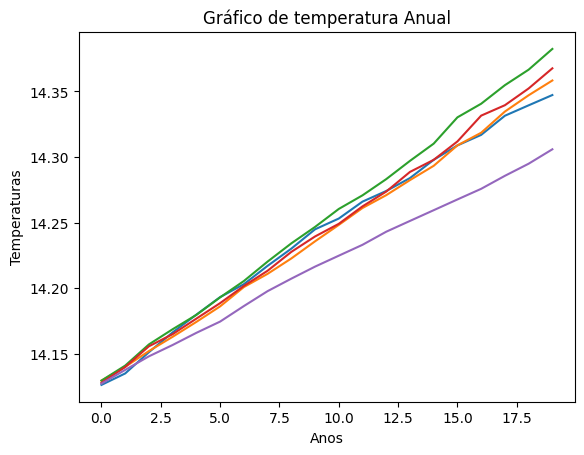

[14.12619323466471, 14.134943117909504, 14.151163625833378, 14.16624972207366, 14.179792765164933, 14.193160323333585, 14.203007446218916, 14.217019645143349, 14.230126985440457, 14.244869194944908, 14.253083216720922, 14.265990626387826, 14.274107932642735, 14.283958084567482, 14.29787212396797, 14.308860369905688, 14.3169028627651, 14.331498985269794, 14.339440982313398, 14.34728814836252] 

[14.129485558136194, 14.139958278739664, 14.152024325983152, 14.16290509669193, 14.17426462282245, 14.186090426113605, 14.200820311072938, 14.210904297632156, 14.222642370963454, 14.235708370739879, 14.248232010388238, 14.261124181325279, 14.270928218405306, 14.282398432469616, 14.293310996702125, 14.308904397320331, 14.318523887137584, 14.33468178821223, 14.347115120381186, 14.358389331952171] 

[14.129485558136194, 14.140919745303014, 14.157084424974204, 14.168667532067243, 14.179604430760056, 14.192973404542027, 14.205429375590485, 14.22024797925107, 14.234154667206985, 14.24668772448025, 14.2

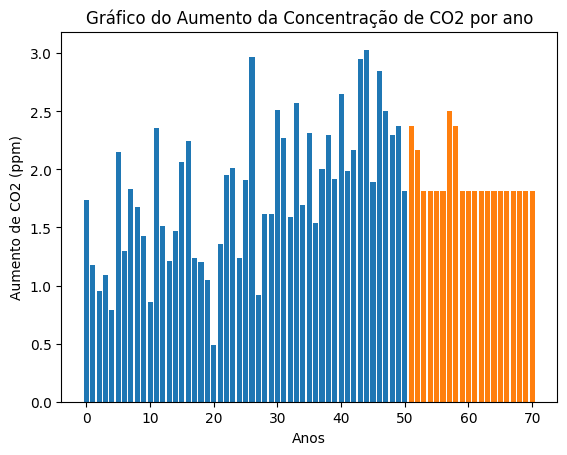

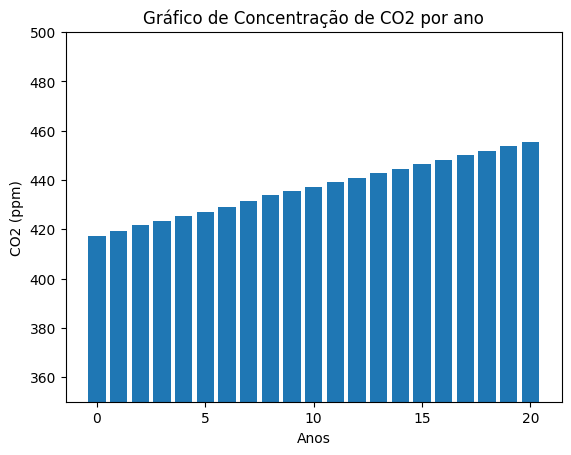

In [7]:
for line in Ts_all:
    plt.plot(range(len(line)),line)
plt.xlabel("Anos")
plt.ylabel("Temperaturas")
plt.title("Gráfico de temperatura Anual")
plt.show()
for line in Ts_all:
    print(line,'\n')

fig,ax=plt.subplots()
CO2_incvalues=list(CO2_increase.values())
cores = ['C0'] * len(CO2_incvalues)
cores[-years:] = ['C1'] * years
ax.bar(range(len(CO2_incvalues)),CO2_incvalues,color=cores)
plt.xlabel("Anos")
plt.ylabel("Aumento de CO2 (ppm)")
plt.title("Gráfico do Aumento da Concentração de CO2 por ano")
plt.show()


fig,ax=plt.subplots()
ax.bar(range(len(CO2_values)),CO2_values)
plt.ylim(350,500)
plt.xlabel("Anos")
plt.ylabel("CO2 (ppm)")
plt.title("Gráfico de Concentração de CO2 por ano")
plt.show()



In [8]:
for i in range(5):
    initial_year=2023
    years = 20

    Ts_values=[]
    CO2_values=[]
    CO2_global_prev = np.mean(CO2_global_2022)
    CO2_values.append(CO2_global_prev)

    for year in range(initial_year,initial_year+years,1):
        # Determine CO2 increase basead on the last 10 years
        rnd = random.randint(1, 10)
        
        increase = CO2_increase[str(year-rnd)]
        CO2_increase[str(year)]=increase
        
        CO2_year = CO2_global_prev+increase
        
        ebm_co2= simple_EBM_seasonal(albedo='step', CO2=CO2_year)
        ebm_co2.integrate_years(1.)
        Ts_year=ebm_co2.global_annual_mean()
            
        Ts_values.append(Ts_year)
        CO2_values.append(CO2_year)
        CO2_global_prev=CO2_year
    
    Ts_all.append(Ts_values)
    CO2_all.append(CO2_values)

Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time

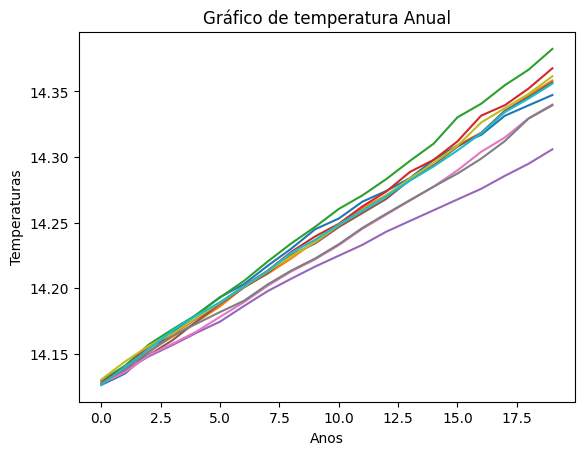

[14.12619323466471, 14.134943117909504, 14.151163625833378, 14.16624972207366, 14.179792765164933, 14.193160323333585, 14.203007446218916, 14.217019645143349, 14.230126985440457, 14.244869194944908, 14.253083216720922, 14.265990626387826, 14.274107932642735, 14.283958084567482, 14.29787212396797, 14.308860369905688, 14.3169028627651, 14.331498985269794, 14.339440982313398, 14.34728814836252] 

[14.129485558136194, 14.139958278739664, 14.152024325983152, 14.16290509669193, 14.17426462282245, 14.186090426113605, 14.200820311072938, 14.210904297632156, 14.222642370963454, 14.235708370739879, 14.248232010388238, 14.261124181325279, 14.270928218405306, 14.282398432469616, 14.293310996702125, 14.308904397320331, 14.318523887137584, 14.33468178821223, 14.347115120381186, 14.358389331952171] 

[14.129485558136194, 14.140919745303014, 14.157084424974204, 14.168667532067243, 14.179604430760056, 14.192973404542027, 14.205429375590485, 14.22024797925107, 14.234154667206985, 14.24668772448025, 14.2

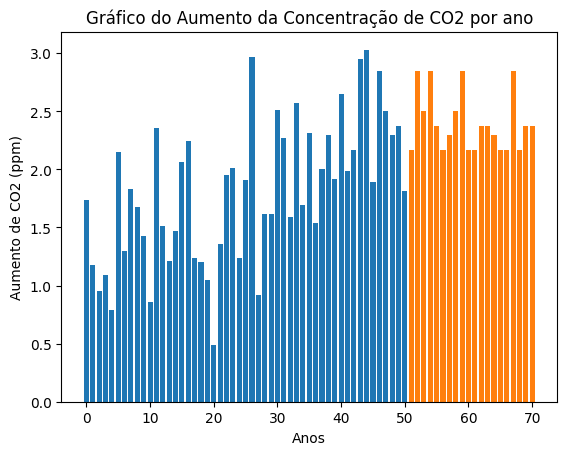

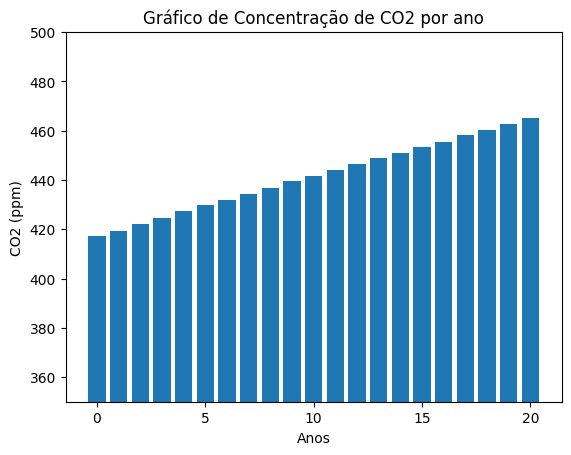

In [9]:
for line in Ts_all:
    plt.plot(range(len(line)),line)
plt.xlabel("Anos")
plt.ylabel("Temperaturas")
plt.title("Gráfico de temperatura Anual")
plt.show()
for line in Ts_all:
    print(line,'\n')

fig,ax=plt.subplots()
CO2_incvalues=list(CO2_increase.values())
cores = ['C0'] * len(CO2_incvalues)
cores[-years:] = ['C1'] * years
ax.bar(range(len(CO2_incvalues)),CO2_incvalues,color=cores)
plt.xlabel("Anos")
plt.ylabel("Aumento de CO2 (ppm)")
plt.title("Gráfico do Aumento da Concentração de CO2 por ano")
plt.show()


fig,ax=plt.subplots()
ax.bar(range(len(CO2_values)),CO2_values)
plt.ylim(350,500)
plt.xlabel("Anos")
plt.ylabel("CO2 (ppm)")
plt.title("Gráfico de Concentração de CO2 por ano")
plt.show()

In [13]:
import numpy as np

Ts_mean=[]
for line in Ts_all:
    Ts_mean.append(np.mean(line))

std = np.std(Ts_mean)
print(std)

0.00956678645258509


In [14]:
from scipy import stats

alpha=0.05
mean = np.mean(Ts_mean)
n = len(Ts_mean)
z = stats.norm.ppf(1 - alpha / 2)
margin_of_error = z * (std / np.sqrt(n))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(confidence_interval)

(14.233035625666224, 14.244894519103086)


In [30]:
print(mean)

14.238965072384655


In [32]:
dTs=[]
for line in Ts_all:
    dTs.append(line[19]-line[0])
print(np.mean(dTs))

0.2237897448250621
